<a href="https://colab.research.google.com/github/Yuanranzhu/SINN/blob/main/FPU_chain_SINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!hostname

gnode011.cluster


In [2]:
!nvidia-smi

Mon Jun 26 19:01:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:31:00.0 Off |                    0 |
| N/A   33C    P0    67W / 300W |      0MiB / 81920MiB |     25%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)

In [4]:
device = torch.device('cuda')

400.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(3000, 400)
(800, 400) (800, 400)
CPU times: user 4min 10s, sys: 52.3 ms, total: 4min 10s
Wall time: 4min 11s


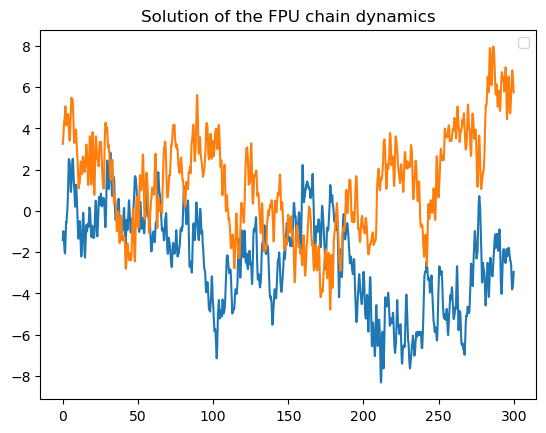

In [5]:
%%time

######### Generating SINN training data by solving SDE
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad


###### Parameters 
mag=1              # Magnitude of the coupling
beta=1             # Inverse temperature 
alpha=1            
gamma=1            # Anharmonic potential U(x)=alpha/2* x^2  + gamma/4* x^4
N=100              # Total number of oscillators in the chain 
N_mid=int(N/2)     # Coordinate of the center CG-oscillator 
dt=0.01 
delta_t=0.1
batch = 400
sec_length = 800

Time = 5*delta_t*sec_length
print(Time)
length=int(Time/dt)+1
t = np.linspace(0,Time,length) # define time axis
gap=int(delta_t/dt)
t_store=t[0:-1:gap]

q_store = np.zeros([t_store.size+1,batch])    # q_store saves the averaged end-to-end length of the whole chain 
q=np.zeros((1,length)) 

p1=np.zeros((N,batch))
q1=np.zeros((N,batch))
p0=np.zeros((N,batch))
q0=np.zeros((N,batch))

# solve SDE

j=1
for i in range(1,length):
    q1=q0+dt*(p0-np.roll(p0,1,axis=0))
    p1=(1-mag*dt)*p0+dt*alpha*(np.roll(q0,-1,axis=0)-q0)+dt*gamma*(np.roll(q0,-1,axis=0)**3-q0**3)+np.sqrt(2*dt*gamma/beta)*np.random.randn(N,batch)
    if i % gap ==0:
        q_store[j,:]=np.sum(q1[0:N_mid-2,:],axis=0)+q1[N_mid-1,:]/2
        j=j+1
    p0=p1
    q0=q1
Toss=int(t_store.size/4)
q_store=q_store[Toss:-1,:]         
print(q_store.shape)



plt.figure(1)
for i in range(2):
    plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,i])
plt.legend()
plt.title("Solution of the FPU chain dynamics")



###########################################   Construct the sample traj for the LSTM learning 
ini=np.random.randn(sec_length,batch)
Traj=q_store[0:sec_length,:]
T=np.arange(len(Traj[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
print(ini.shape, Traj.shape)



In [6]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 1), device=device)

Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch,1)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([1600, 400, 1]) torch.float32
The torch validation size is torch.Size([1600, 400, 1]) torch.float32
The torch target size is torch.Size([800, 400, 1]) torch.float32


In [7]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_q2 = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)
loss_pdf_empirical = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=10, device=device)
# loss_pdf_exact = make_loss('pdf', PDF_exact, lower=-5, upper=5, n=N, device=device)

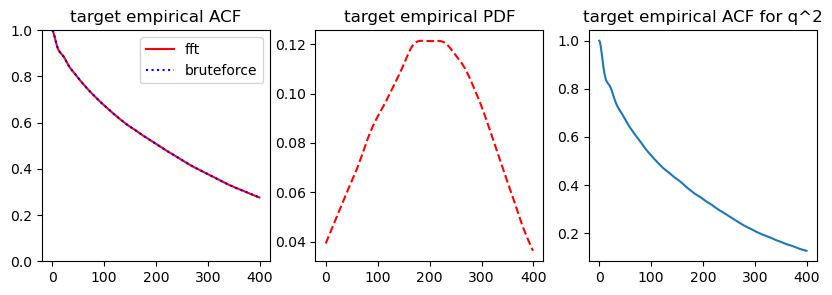

In [8]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].plot(loss_acf_fft._target.cpu(),'r', label='fft')
axs[0].plot(loss_acf_bruteforce._target.cpu(),'b:', label='bruteforce')
axs[0].set_title('target empirical ACF')
axs[0].set_ylim([0,1])
x_grid=-np.linspace(-5,5,num=sec_length)
axs[1].plot(loss_pdf_empirical._target.cpu(),'r--')
axs[1].set_title('target empirical PDF')
axs[2].plot(loss_acf_q2._target.cpu())
axs[2].set_title('target empirical ACF for q^2')
axs[0].legend()
plt.show()

In [9]:
### Defining SINN model
net = SINN(1, 25, 2, 1).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [10]:
%%time
# Training SINN
T_error=[]
V_error=[]
T_acf=[]
V_acf=[]
T_pdf=[]
V_pdf=[]
T_acf2=[]
V_acf2=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_fft(prediction) + loss_pdf_empirical(prediction) + loss_acf_q2(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_empirical(pred_val) + loss_acf_q2(pred_val**2)
            acf = loss_acf_bruteforce(pred_val)
            pdf = loss_pdf_empirical(pred_val)
            acf_sec_moment = loss_acf_q2(pred_val**2)
            loss_val_acf = loss_acf_bruteforce(pred_val)
            print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, pdf: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, pdf, acf_sec_moment))
            T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
            V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
            T_pdf.append(loss_pdf_empirical(prediction).detach().cpu().numpy())
            V_pdf.append(loss_pdf_empirical(pred_val).detach().cpu().numpy())
            T_acf2.append(loss_acf_q2(prediction**2).detach().cpu().numpy())
            V_acf2.append(loss_acf_q2(pred_val**2).detach().cpu().numpy())
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.0005 and loss_val<=0.0005:
            break
print('Training finished')

[0]-th step loss: 0.5848, 0.5781, acf: 0.31489, pdf: 0.07758, acf2: 0.18560
[50]-th step loss: 0.3786, 0.1848, acf: 0.08977, pdf: 0.07313, acf2: 0.02184
[100]-th step loss: 0.4665, 0.4679, acf: 0.25655, pdf: 0.07777, acf2: 0.13363
[150]-th step loss: 0.2559, 0.1366, acf: 0.05083, pdf: 0.07808, acf2: 0.00769
[200]-th step loss: 0.1010, 0.1043, acf: 0.02274, pdf: 0.07834, acf2: 0.00324
[250]-th step loss: 0.0703, 0.0704, acf: 0.01344, pdf: 0.03415, acf2: 0.02278
[300]-th step loss: 0.0728, 0.0717, acf: 0.01338, pdf: 0.03542, acf2: 0.02294
[350]-th step loss: 0.0716, 0.0713, acf: 0.01338, pdf: 0.03503, acf2: 0.02293
[400]-th step loss: 0.0710, 0.0710, acf: 0.01338, pdf: 0.03470, acf2: 0.02292
[450]-th step loss: 0.0699, 0.0707, acf: 0.01338, pdf: 0.03441, acf2: 0.02289
[500]-th step loss: 0.0697, 0.0698, acf: 0.01338, pdf: 0.03354, acf2: 0.02284
[550]-th step loss: 0.0691, 0.0684, acf: 0.01338, pdf: 0.03233, acf2: 0.02270
[600]-th step loss: 0.0657, 0.0661, acf: 0.01339, pdf: 0.03181, acf

[5200]-th step loss: 0.0667, 0.0670, acf: 0.01338, pdf: 0.03103, acf2: 0.02264
[5250]-th step loss: 0.0487, 0.0480, acf: 0.01337, pdf: 0.03223, acf2: 0.00241
[5300]-th step loss: 0.0479, 0.0461, acf: 0.01321, pdf: 0.03074, acf2: 0.00217
[5350]-th step loss: 0.0416, 0.0411, acf: 0.01378, pdf: 0.02520, acf2: 0.00210
[5400]-th step loss: 0.0382, 0.0382, acf: 0.01504, pdf: 0.02109, acf2: 0.00210
[5450]-th step loss: 0.0374, 0.0383, acf: 0.01497, pdf: 0.02127, acf2: 0.00205
[5500]-th step loss: 0.0361, 0.0369, acf: 0.01596, pdf: 0.01895, acf2: 0.00197
[5550]-th step loss: 0.0370, 0.0363, acf: 0.01630, pdf: 0.01809, acf2: 0.00193
[5600]-th step loss: 0.0373, 0.0376, acf: 0.01650, pdf: 0.01922, acf2: 0.00190
[5650]-th step loss: 0.0368, 0.0396, acf: 0.01707, pdf: 0.02002, acf2: 0.00248
[5700]-th step loss: 0.0358, 0.0386, acf: 0.01694, pdf: 0.01963, acf2: 0.00200
[5750]-th step loss: 0.0370, 0.0388, acf: 0.01647, pdf: 0.02028, acf2: 0.00201
[5800]-th step loss: 0.0361, 0.0371, acf: 0.01737, p

[10400]-th step loss: 0.0212, 0.0210, acf: 0.01375, pdf: 0.00538, acf2: 0.00183
[10450]-th step loss: 0.0211, 0.0209, acf: 0.01386, pdf: 0.00526, acf2: 0.00180
[10500]-th step loss: 0.0212, 0.0209, acf: 0.01373, pdf: 0.00540, acf2: 0.00179
[10550]-th step loss: 0.0212, 0.0210, acf: 0.01352, pdf: 0.00564, acf2: 0.00186
[10600]-th step loss: 0.0216, 0.0209, acf: 0.01373, pdf: 0.00537, acf2: 0.00182
[10650]-th step loss: 0.0210, 0.0209, acf: 0.01389, pdf: 0.00520, acf2: 0.00179
[10700]-th step loss: 0.0215, 0.0209, acf: 0.01405, pdf: 0.00505, acf2: 0.00180
[10750]-th step loss: 0.0212, 0.0208, acf: 0.01369, pdf: 0.00537, acf2: 0.00179
[10800]-th step loss: 0.0209, 0.0208, acf: 0.01372, pdf: 0.00532, acf2: 0.00180
[10850]-th step loss: 0.0209, 0.0208, acf: 0.01370, pdf: 0.00534, acf2: 0.00178
[10900]-th step loss: 0.0211, 0.0209, acf: 0.01369, pdf: 0.00528, acf2: 0.00192
[10950]-th step loss: 0.0206, 0.0208, acf: 0.01392, pdf: 0.00504, acf2: 0.00180
[11000]-th step loss: 0.0209, 0.0208, ac

[15550]-th step loss: 0.0879, 0.0314, acf: 0.01316, pdf: 0.00836, acf2: 0.00992
[15600]-th step loss: 0.0407, 0.0401, acf: 0.01313, pdf: 0.00542, acf2: 0.02157
[15650]-th step loss: 0.0214, 0.0209, acf: 0.01352, pdf: 0.00489, acf2: 0.00248
[15700]-th step loss: 0.0207, 0.0206, acf: 0.01374, pdf: 0.00446, acf2: 0.00242
[15750]-th step loss: 0.0204, 0.0205, acf: 0.01364, pdf: 0.00448, acf2: 0.00237
[15800]-th step loss: 0.0206, 0.0204, acf: 0.01369, pdf: 0.00431, acf2: 0.00244
[15850]-th step loss: 0.0202, 0.0203, acf: 0.01370, pdf: 0.00430, acf2: 0.00227
[15900]-th step loss: 0.0204, 0.0203, acf: 0.01386, pdf: 0.00404, acf2: 0.00236
[15950]-th step loss: 0.0201, 0.0202, acf: 0.01388, pdf: 0.00404, acf2: 0.00224
[16000]-th step loss: 0.0200, 0.0201, acf: 0.01387, pdf: 0.00409, acf2: 0.00212
[16050]-th step loss: 0.0200, 0.0200, acf: 0.01382, pdf: 0.00417, acf2: 0.00202
[16100]-th step loss: 0.0206, 0.0200, acf: 0.01382, pdf: 0.00421, acf2: 0.00197
[16150]-th step loss: 0.0200, 0.0200, ac

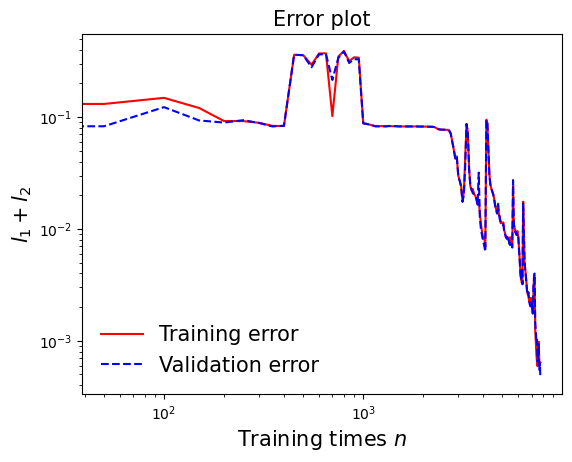

In [46]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/CG_training_error.pdf", dpi=150)


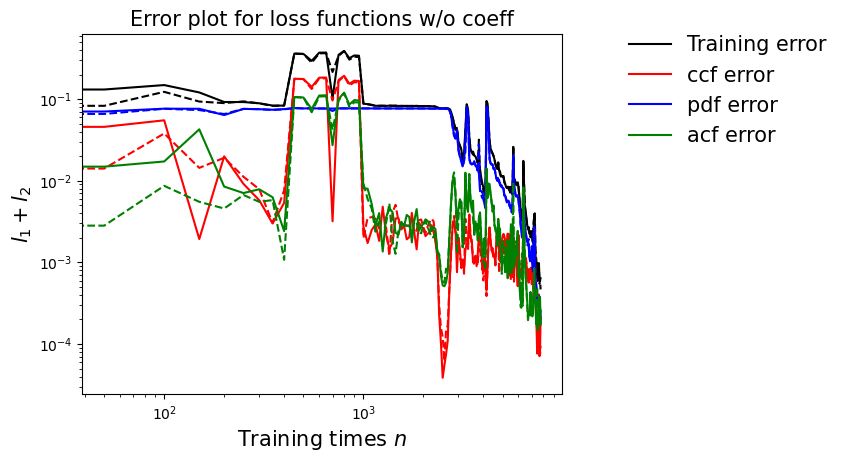

In [47]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot for loss functions w/o coeff",fontsize=15) 
plt.loglog(Step, T_error,'k',label='Training error')
plt.loglog(Step, V_error,'k--')
plt.loglog(Step, T_acf,'r',label='ccf error')
plt.loglog(Step, V_acf,'r--')
plt.loglog(Step, T_pdf,'b',label='pdf error')
plt.loglog(Step, V_pdf,'b--')
plt.loglog(Step, T_acf2,'g',label='acf error')
plt.loglog(Step, V_acf2,'g--')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

In [48]:
# # Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred,_= net(ran_input)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch)

([<matplotlib.axis.YTick at 0x1503cc256ee0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

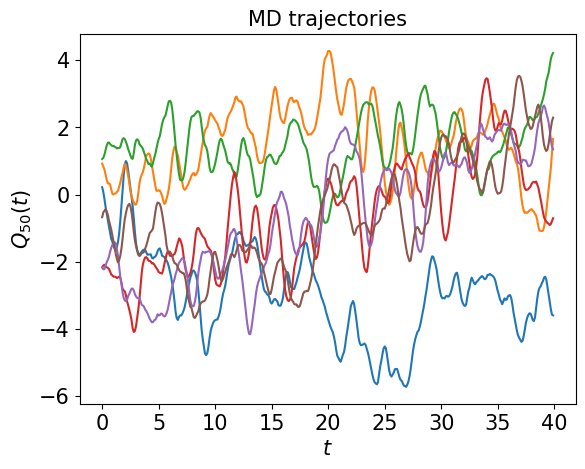

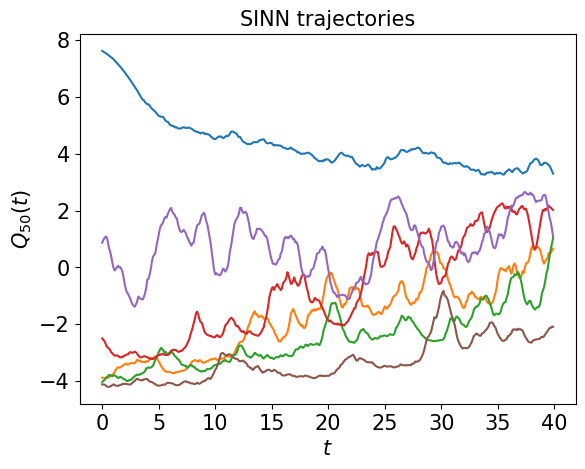

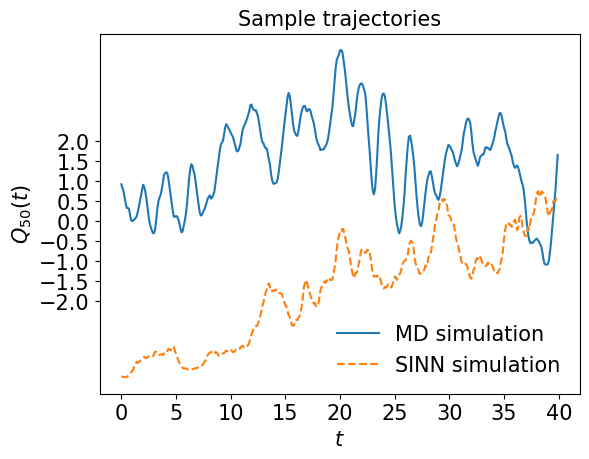

In [50]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

plt.figure(0) 
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
plt.plot(T[skip:]-T[skip], Traj[skip:, 1])
plt.plot(T[skip:]-T[skip], Traj[skip:, 2])
plt.plot(T[skip:]-T[skip], Traj[skip:, -1])
plt.plot(T[skip:]-T[skip], Traj[skip:, -2])
plt.plot(T[skip:]-T[skip], Traj[skip:, -3])    
# plt.ylim([-1.5,1.5])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$Q_{50}(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)     


plt.figure(1)
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
plt.plot(T[skip:]-T[skip], prediction[skip:, 1])
plt.plot(T[skip:]-T[skip], prediction[skip:, 2])
plt.plot(T[skip:]-T[skip], prediction[skip:, -1])
plt.plot(T[skip:]-T[skip], prediction[skip:, -2])
plt.plot(T[skip:]-T[skip], prediction[skip:, -3])
# plt.ylim([-1.5,1.5])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$Q_{50}(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 1], label='MD simulation')
# plt.plot(T[skip:]-T[skip], Traj[skip:, 1],'r')
plt.plot(T[skip:]-T[skip], prediction[skip:, 1],'--',label='SINN simulation')
# plt.plot(T[skip:]-T[skip], prediction[skip:, 1],'b')
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$Q_{50}(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)
# plt.savefig("figs/CG_traj.pdf", dpi=150)





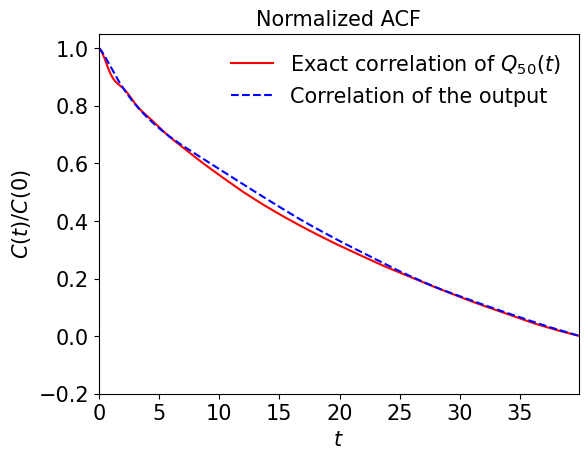

In [51]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF   

# acf_p=StatLoss.acf(Pred[-sec_length:,:,:],method='bruteforce')
acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
acf_t=StatLoss.acf(target)
corr_p=acf_p.mean(axis=1).detach().cpu().numpy()
corr_t=acf_t.mean(axis=1).detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, corr_t,'r',label=r'Exact correlation of $Q_{50}(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')        # Correlation function after the training      # Correlation function after the training 
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0,T[-1])
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/CG_acf.pdf", dpi=150)




(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

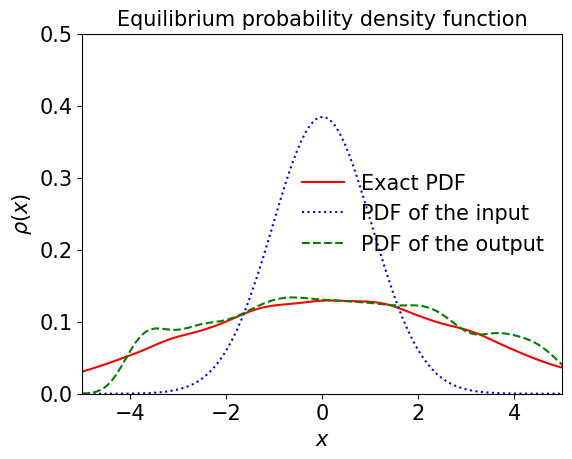

In [56]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
rho_data =  StatLoss.gauss_kde(target, -5, 5, 100,10).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100,10).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100,10).cpu()


x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy(), 'r',label=r'Exact PDF')    # target PDF
plt.plot(x, rho_input.numpy(), 'b:', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy(), 'g--',label=r'PDF of the output')  # PDF after the training 
plt.xlim(-5,5)
plt.ylim(0,0.5)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/CG_pdf.pdf", dpi=150)



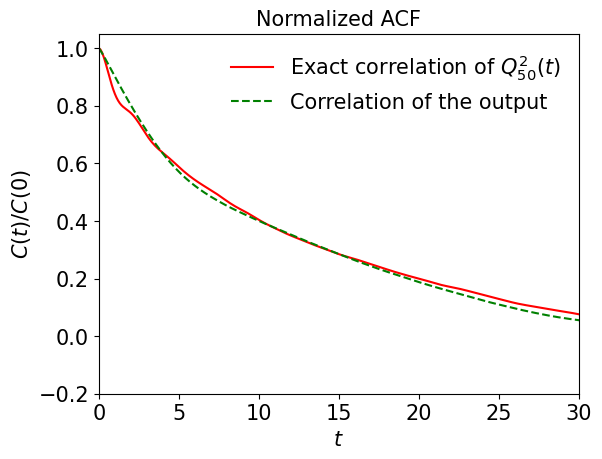

In [57]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,1))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'r',label=r'Exact correlation of $Q_{50}^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training 
plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/CG_acf2.pdf", dpi=150)




(array([  0., 100., 200., 300., 400., 500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

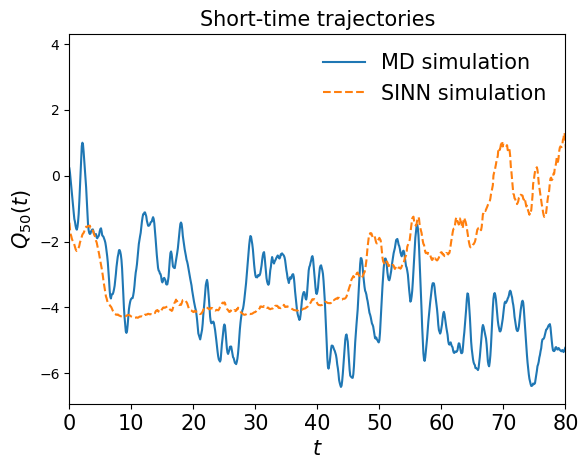

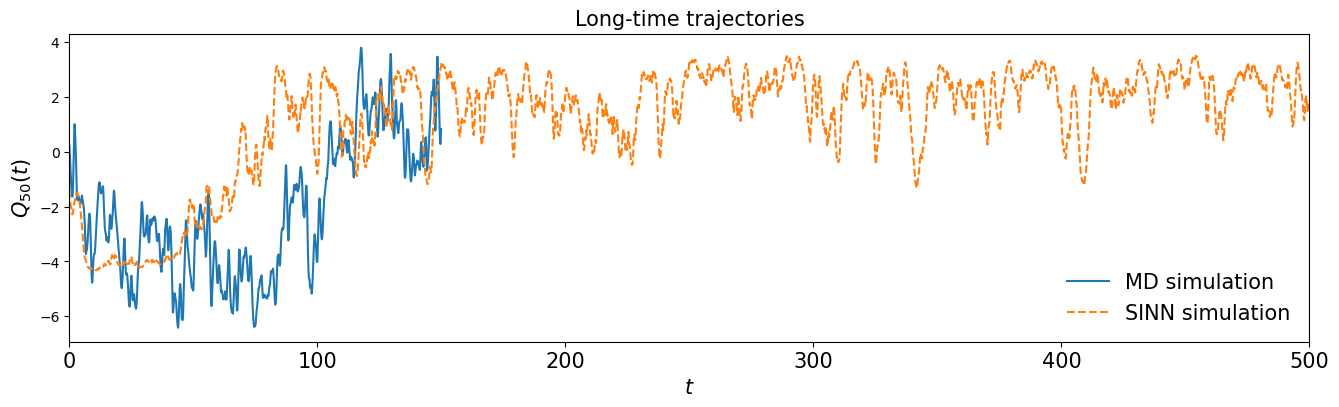

In [60]:
# Test 5: plot the expolation result, i.e. Prediction of the dynamics of the 
# CG partilce in the FPU-chain for longer time 
[a,b,c]=input.size()
skip=20
scale=10
burnin=3
fold=800
batch_new=50
ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
Pred_L, _= net(ran_input)
prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new)
acf_p=StatLoss.acf(Pred_L,method='bruteforce')

LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
LT=LT[0:-1]


fig = plt.figure(0)
# ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 1],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$Q_{50}(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/CG_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
# ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 1],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$Q_{50}(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/CG_traj_lT.pdf", dpi=150)




